In [ ]:
# %%
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import keras.utils as image
from keras.applications import MobileNetV3Large
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from sklearn.metrics import matthews_corrcoef
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

/tmp/ipykernel_2881651/36594185.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-10 23:03:02.473286: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 23:03:02.838202: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 23:03

In [ ]:
# %%
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# %%
# Define directories
train_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/train'
test_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/test'


In [3]:
# %%
image_size = (224, 224, 3)

# %%
# Function to load images
def load_images(directory):
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)

In [4]:
# %%
# Load training and test images
train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)

# Preprocess images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [5]:
# Load MobileNetV3 (large) with pre-trained weights on ImageNet
base_mobilenetv3_large = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='None')

# Add Global Average Pooling (GAP) layer
x = base_mobilenetv3_large.output
x = GlobalAveragePooling2D()(x)

# Create the model
mobilenetv3_large_with_gap = Model(inputs=base_mobilenetv3_large.input, outputs=x)


2024-04-10 23:03:31.695504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13699 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0


In [6]:
# Function to extract features
def extract_features(model, images, batch_size):
    num_images = images.shape[0]
    features = []
    for start_idx in range(0, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        batch = images[start_idx:end_idx]
        batch_features = model.predict(batch)
        features.append(batch_features)
    return np.concatenate(features)


In [7]:

batch_size = 8
# Extract features using MobileNetV3 (large)
train_features = extract_features(mobilenetv3_large_with_gap, train_images, batch_size)
test_features = extract_features(mobilenetv3_large_with_gap, test_images, batch_size)

2024-04-10 23:03:34.336449: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-10 23:03:34.410557: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1/1 [==============================] - 0s 36ms/step


2024-04-10 23:03:34.796353: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-04-10 23:03:34.841947: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


1/1 [==============================] - 0s 114ms/step


In [8]:
# %%
# Define the parameter grid for SVM
svm_param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

# Create SVM classifier
svm_classifier = SVC()

# Use GridSearchCV to find the best parameters for SVM
svm_grid_search = GridSearchCV(svm_classifier, svm_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
svm_grid_search.fit(train_features, train_labels)

# Get the best parameters for SVM
best_svm_params = svm_grid_search.best_params_

# Train the final SVM model with the best parameters
final_svm_classifier = SVC(**best_svm_params)
start_time_svm = time.time()
final_svm_classifier.fit(train_features, train_labels)
train_time_svm = time.time() - start_time_svm

# Predict labels for the test set using SVM
svm_predictions = final_svm_classifier.predict(test_features)

# Evaluate accuracy for SVM
svm_accuracy = accuracy_score(test_labels, svm_predictions)
print("\nBest SVM Parameters:", best_svm_params)
print("SVM Accuracy:", svm_accuracy)


Best SVM Parameters: {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
SVM Accuracy: 0.9864158829676071


In [9]:
# %%
# Additional evaluation metrics for SVM
precision_svm = precision_score(test_labels, svm_predictions, average='weighted')
recall_svm = recall_score(test_labels, svm_predictions, average='weighted')
f1_svm = f1_score(test_labels, svm_predictions, average='weighted')

print("Train Time (sec) SVM:", train_time_svm)
grid_train_time_svm = svm_grid_search.cv_results_['mean_fit_time'][svm_grid_search.best_index_]
print("Train Time (sec) Grid SVM:", grid_train_time_svm)

# Calculate Matthews Correlation Coefficient (MCC) for SVM
mcc_svm = matthews_corrcoef(test_labels, svm_predictions)
print("Matthews Correlation Coefficient (MCC) SVM:", mcc_svm)

# Accuracy for optimization algorithm (GridSearchCV)
optimization_accuracy_svm = svm_grid_search.best_score_
print("Optimization Algorithm Accuracy SVM:", optimization_accuracy_svm)

Train Time (sec) SVM: 1.617292881011963
Train Time (sec) Grid SVM: 3.9750163555145264
Matthews Correlation Coefficient (MCC) SVM: 0.9841842031429783
Optimization Algorithm Accuracy SVM: 0.9794879201830747


In [10]:
# %%
# Confusion matrix for SVM
conf_matrix_svm = confusion_matrix(test_labels, svm_predictions)
precision_svm = precision_score(test_labels, svm_predictions, average='weighted')

FP_svm = conf_matrix_svm.sum(axis=0) - np.diag(conf_matrix_svm)
FN_svm = conf_matrix_svm.sum(axis=1) - np.diag(conf_matrix_svm)
TP_svm = np.diag(conf_matrix_svm)
TN_svm = conf_matrix_svm.sum()

# %%
# Display results for SVM
print("\nResults for SVM:")
print("Precision (SVM):", precision_svm)
print("Recall (SVM):", recall_svm)
print("F1 Score (SVM):", f1_svm)
print("True Positive Rate (TPR) (SVM):", np.mean(TP_svm / (TP_svm + FN_svm)))
print("True Negative Rate (TNR) (SVM):", np.mean(TN_svm / (TN_svm + FP_svm)))
print("False Positive Rate (FPR) (SVM):", np.mean(FP_svm / (FP_svm + TN_svm)))
print("False Negative Rate (FNR) (SVM):", np.mean(FN_svm / (TP_svm + FN_svm)))
print("False Discovery Rate (FDR) (SVM):", np.mean(FP_svm / (FP_svm + TP_svm)))
print("False Omission Rate (FOR) (SVM):", np.mean(FN_svm / (FN_svm + TN_svm)))
print("Matthews Correlation Coefficient (MCC) (SVM):", mcc_svm)


Results for SVM:
Precision (SVM): 0.9867897220221057
Recall (SVM): 0.9864158829676071
F1 Score (SVM): 0.98641656663607
True Positive Rate (TPR) (SVM): 0.9659071320836027
True Negative Rate (TNR) (SVM): 0.9994587642024206
False Positive Rate (FPR) (SVM): 0.0005412357975793287
False Negative Rate (FNR) (SVM): 0.034092867916397325
False Discovery Rate (FDR) (SVM): 0.03464389233954451
False Omission Rate (FOR) (SVM): 0.0005413209804074705
Matthews Correlation Coefficient (MCC) (SVM): 0.9841842031429783


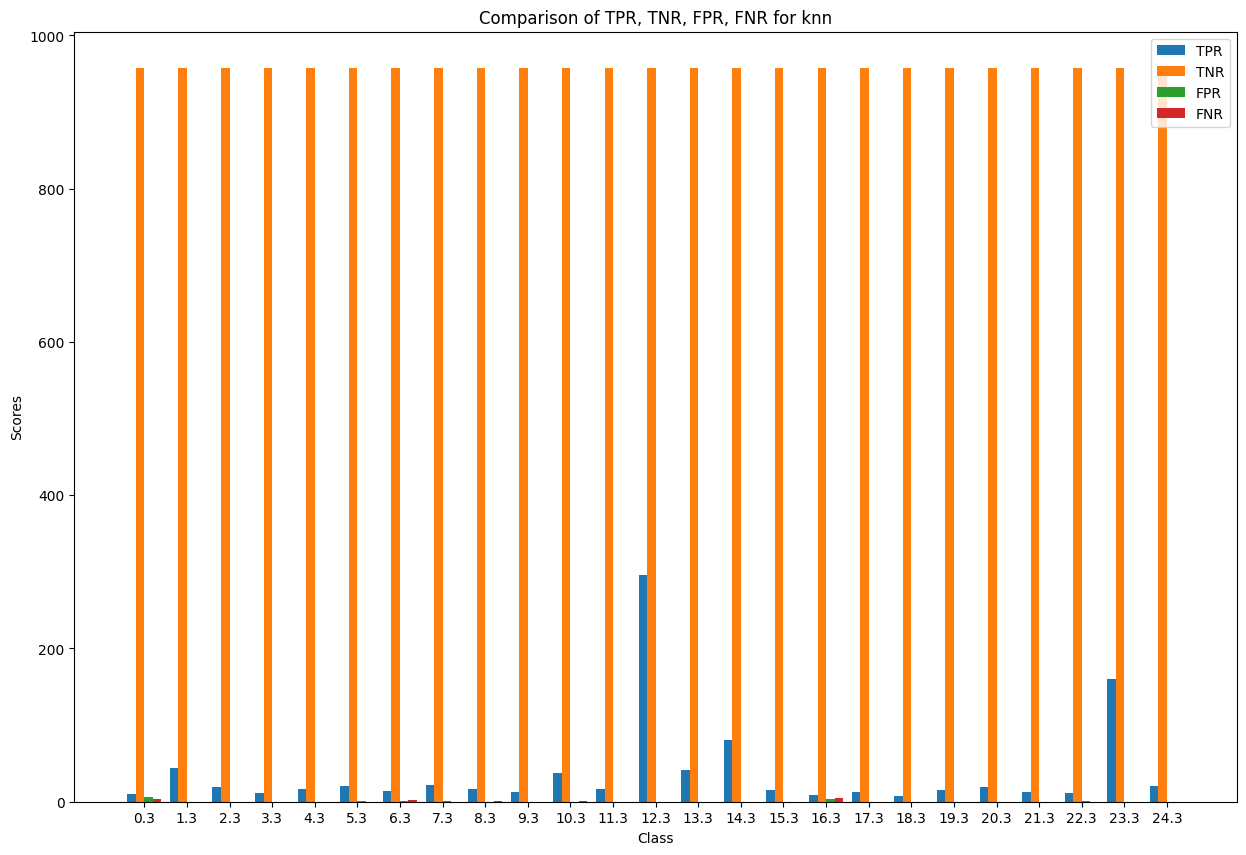

In [11]:
# Plot TPR, TNR, FPR, FNR
fig, ax = plt.subplots(figsize=(15, 10))

bar_width = 0.2
index = np.arange(25)  # Assuming you have 25 classes, adjust this based on your data

bar1 = ax.bar(index, TP_svm, bar_width, label='TPR')
bar2 = ax.bar(index + bar_width, TN_svm, bar_width, label='TNR')
bar3 = ax.bar(index + 2 * bar_width, FP_svm, bar_width, label='FPR')
bar4 = ax.bar(index + 3 * bar_width, FN_svm, bar_width, label='FNR')

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Comparison of TPR, TNR, FPR, FNR for knn')
ax.set_xticks(index + 1.5 * bar_width)
ax.legend()

plt.show()

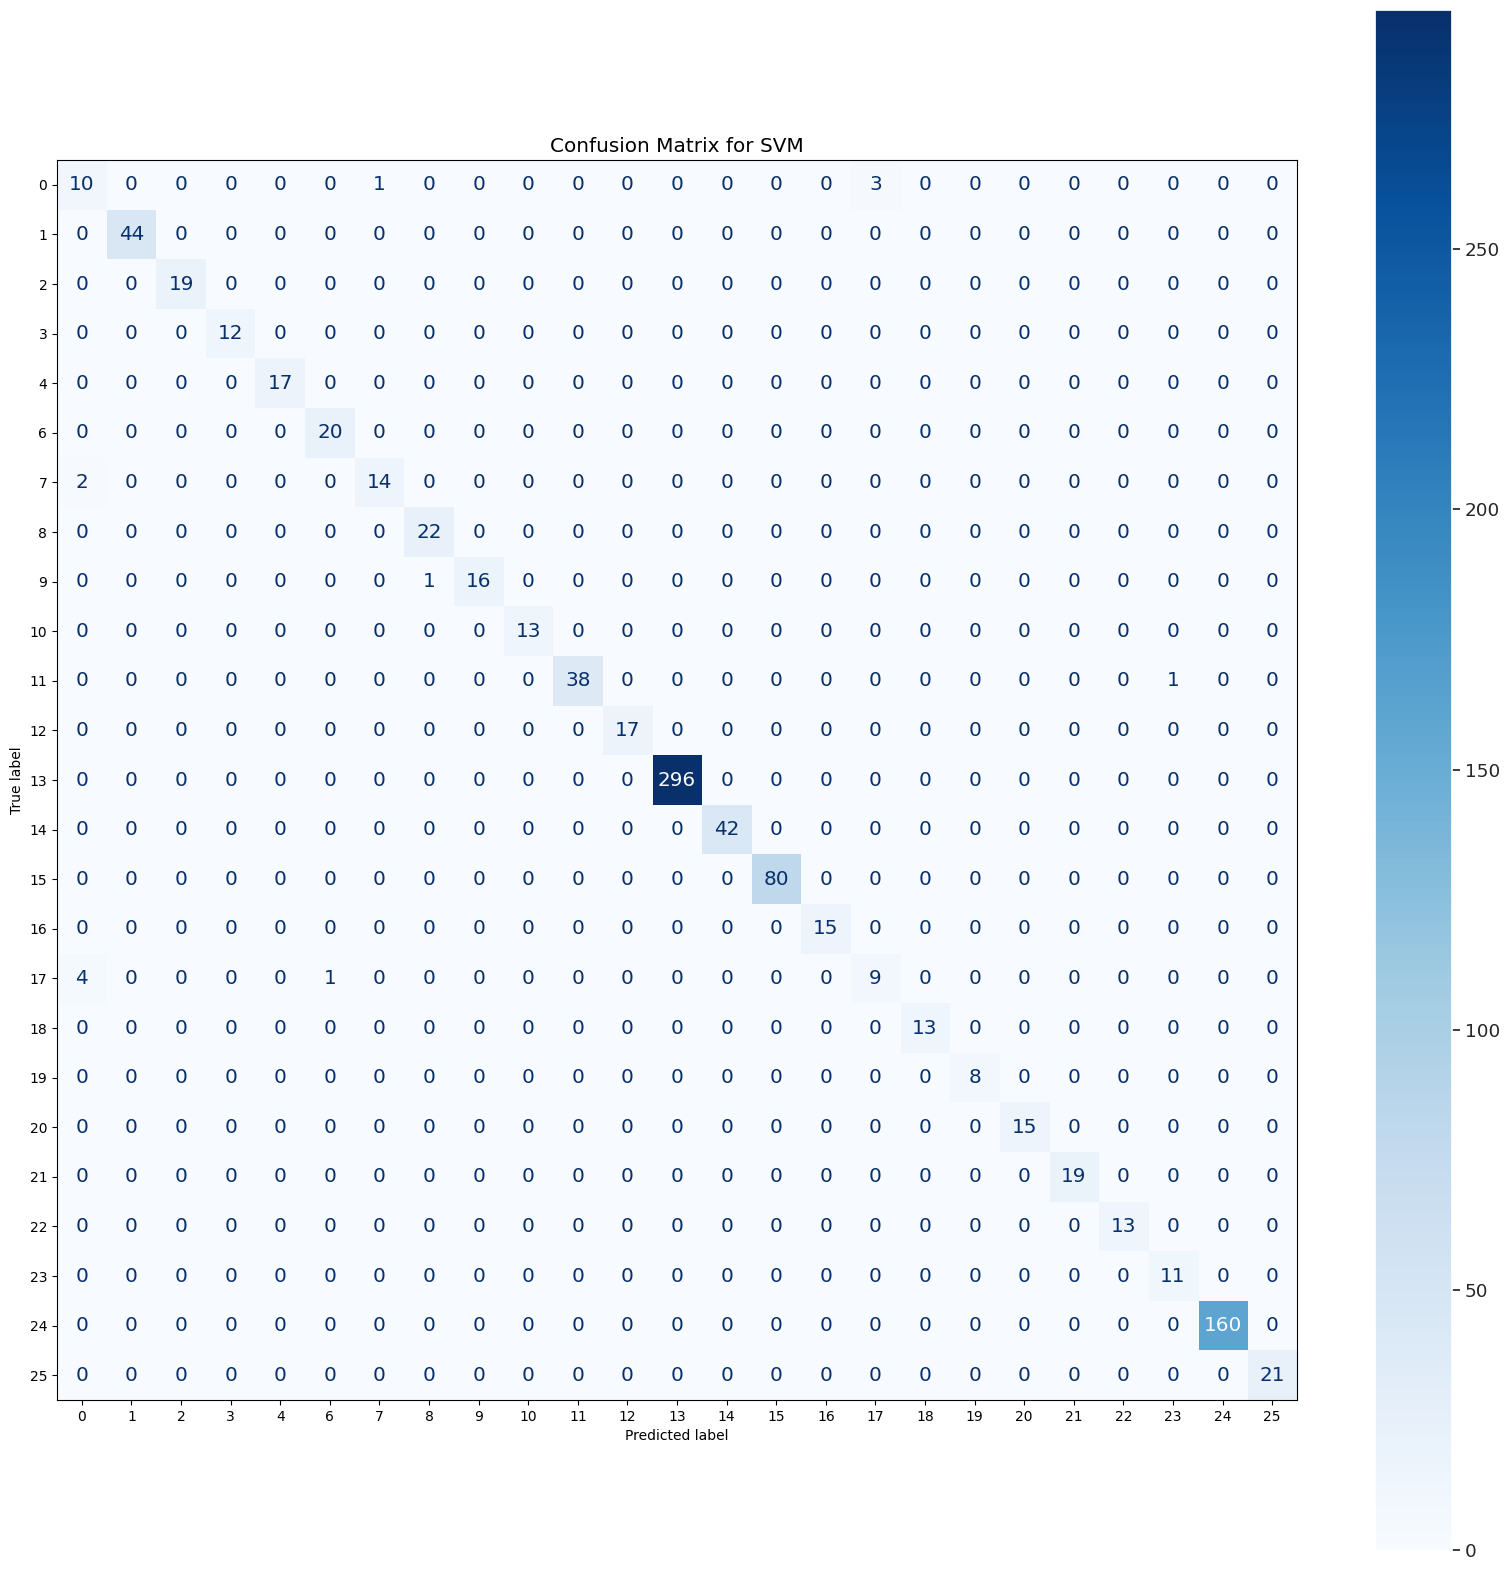

In [12]:
# %%
# Plot Confusion Matrix for SVM
fig, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.2)  # Adjust font size for better readability
disp = ConfusionMatrixDisplay(conf_matrix_svm, display_labels=np.unique(test_labels))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix for SVM')
plt.show()
